# ISPR Midterm 3
# Alessandro Trenta - 566072
## Assignment 4


Mount GDrive to import the csv files of the dataset

Import necessary libraries

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import re
import os
import datetime
import time

load tensorboard extension

In [2]:
%load_ext tensorboard

## Data import and clean

Import the main csv file containing all presidential speeches

In [3]:
# Import the csv file in a pandas dataframe
raw_speeches = pd.read_csv('./archive/presidential_speeches.csv',encoding = "UTF-8")
raw_speeches.head()

,Date,President,Party,Speech Title,Summary,Transcript,URL
0,1789-04-30,George Washington,Unaffiliated,First Inaugural Address,Washington calls on Congress to avoid local an...,Fellow Citizens of the Senate and the House of...,https://millercenter.org/the-presidency/presid...
1,1789-10-03,George Washington,Unaffiliated,Thanksgiving Proclamation,"At the request of Congress, Washington establi...",Whereas it is the duty of all Nations to ackno...,https://millercenter.org/the-presidency/presid...
2,1790-01-08,George Washington,Unaffiliated,First Annual Message to Congress,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...
3,1790-12-08,George Washington,Unaffiliated,Second Annual Message to Congress,Washington focuses on commerce in his second a...,Fellow citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...
4,1790-12-29,George Washington,Unaffiliated,Talk to the Chiefs and Counselors of the Senec...,The President reassures the Seneca Nation that...,"I the President of the United States, by my ow...",https://millercenter.org/the-presidency/presid...


Now we filter only the speeches from President Clinton

In [4]:
clinton = raw_speeches[raw_speeches['President']=='Bill Clinton']
clinton.head()

,Date,President,Party,Speech Title,Summary,Transcript,URL
845,1993-01-20,Bill Clinton,Democratic,First Inaugural,As the first President elected in the post-Col...,"My fellow citizens, today we celebrate the mys...",https://millercenter.org/the-presidency/presid...
846,1993-01-29,Bill Clinton,Democratic,"Press Conference on ""Gays in the Military""",President Bill Clinton addresses the press reg...,"The President. Good afternoon, ladies and gent...",https://millercenter.org/the-presidency/presid...
847,1993-02-05,Bill Clinton,Democratic,Remarks at the Signing of the Family Medical L...,President Clinton signs the Family Medical Lea...,"Thank you very much, thank you. Mrs. Yandle, I...",https://millercenter.org/the-presidency/presid...
848,1993-02-17,Bill Clinton,Democratic,Address Before a Joint Session of Congress,Clinton gives the economy his primary focus. H...,"Mr. President, Mr. Speaker, Members of the Hou...",https://millercenter.org/the-presidency/presid...
849,1993-04-30,Bill Clinton,Democratic,National Service Address,"On the 100th day of his administration, Presid...",It is wonderful to be back in New Orleans and ...,https://millercenter.org/the-presidency/presid...


There are 39 speeches from President Clinton in total

In [5]:
print(clinton.shape)

(39, 7)


Here we do the same filtering but on the President Trump speeches

In [6]:
trump = raw_speeches[raw_speeches['President']=='Donald Trump']
trump.head()

,Date,President,Party,Speech Title,Summary,Transcript,URL
973,2017-01-20,Donald Trump,Republican,Inaugural Address,"Donald J. Trump was inaugurated on January 20,...","Chief Justice Roberts, President Carter, Presi...",https://millercenter.org/the-presidency/presid...
974,2017-02-28,Donald Trump,Republican,Address to Joint Session of Congress,NaN,"Mr. Speaker, Mr. Vice President, Members of Co...",https://millercenter.org/the-presidency/presid...
975,2017-06-29,Donald Trump,Republican,Speech at the Unleashing American Energy Event,President Donald Trump talks about his adminis...,"Thank you, everybody. Thank you very much. How...",https://millercenter.org/the-presidency/presid...
976,2017-07-24,Donald Trump,Republican,Speech at the Boy Scout Jamboree,President Trump addresses the Boy Scout Jambor...,"TRUMP: Thank you, everybody. Thank you very mu...",https://millercenter.org/the-presidency/presid...
977,2017-09-19,Donald Trump,Republican,Address to the United Nations General Assembly,President Trump addresses the 72nd session of ...,"Mr. Secretary General, Mr. President, world le...",https://millercenter.org/the-presidency/presid...


There are 19 Trump speeches in total

In [7]:
print(trump.shape)

(19, 7)


We are now going to select only the transcripts of the speeches and collect them.

In [8]:
clinton_speeches = clinton['Transcript'].to_numpy()
trump_speeches = trump['Transcript'].to_numpy()
all_speeches = np.concatenate((clinton_speeches, trump_speeches))
print(all_speeches.shape)

(58,)


### Preprocessing
Transcripts of presidential speeches are almost clean as we also want to keep the punctuation. The only charachters giving problems are the double quote (") chars. We are going to remove all charachters from \x00 to \xff.

In [9]:
def preprocess(data):
  # Clean data array
  clean_data = []
  for i, transcript in enumerate(data):
    # Clean the transcript using regular expressions
    clean_data.append(re.sub('[^\x00-\xff]','', transcript))
  return np.array(clean_data)

The following function merges all the presidential speeches to simplify the follwing passages. This way we can divide in small parts the corpora in a simpler way

In [10]:
def join_transcripts(data):
  joined = ''
  for transcript in data:
    joined = joined+' '+transcript
  return joined

Use the functions on datasets

In [11]:
clinton_clean = join_transcripts(preprocess(clinton_speeches))
trump_clean = join_transcripts(preprocess(trump_speeches))
all_clean = join_transcripts(preprocess(all_speeches))

### Char vocabulary generation
The following function generates the set of all charachters. The aim is to have a conversion table from char to a numerical id and viceversa.

In [12]:
def get_char_vocabulary(data):
  # Empty set
  vocab = set()
  for transcript in data:
    # Update the vocabulary set with the new chars from the transcript
    vocab.update(set(transcript))
  return sorted(vocab)

Here we generate the vocabulary.

We have a total of 80 chars and all of them are alphanumerical, brackets or punctuation symbols. We have some special charachters but no more strange codes or non-trivial chars.

In [13]:
vocab = get_char_vocabulary(all_clean)
print(f'Vocabulary has {len(vocab)} charachters')
print(vocab)

Vocabulary has 80 charachters
[' ', '!', '"', '$', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é']


In this next step we divide the presidential speeches ensembles into single chars.

In [14]:
clinton_chars = tf.strings.unicode_split(clinton_clean, input_encoding='UTF-8')
trump_chars = tf.strings.unicode_split(trump_clean, input_encoding='UTF-8')
all_chars = tf.strings.unicode_split(all_clean, input_encoding='UTF-8')

### Char-ids-text conversions
The following "functions" will be used to convert from char to numerical id and viceversa with an additional function to reconstruct a complete text string from an array of ids.

In [15]:
# This functions are in reality keras layers that convert strings and ids
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)
chars_from_ids = tf.keras.layers.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)
# Function for ids to text conversion
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

Generate the ids datasets

In [16]:
clinton_ids = ids_from_chars(clinton_chars)
trump_ids = ids_from_chars(trump_chars)
all_ids = ids_from_chars(all_chars)

## Sentences subdivision


In [17]:
sentences_length = 100
train_split = 0.85
clinton_raw = tf.data.Dataset.from_tensor_slices(clinton_ids)
clinton_batched = clinton_raw.batch(sentences_length+1, drop_remainder=True)
clinton_size = clinton_batched.cardinality().numpy()
clinton_train_size = int(clinton_size*train_split)
clinton_val_size = clinton_size - clinton_train_size
clinton_train_sent = clinton_batched.take(clinton_train_size)
clinton_val_sent = clinton_batched.skip(clinton_train_size)
print(f"Clinton train size: {clinton_train_size}, Clinton validation size: {clinton_val_size}")

trump_raw = tf.data.Dataset.from_tensor_slices(trump_ids)
trump_batched = trump_raw.batch(sentences_length+1, drop_remainder=True)
trump_size = trump_batched.cardinality().numpy()
trump_train_size = int(trump_size*train_split)
trump_val_size = trump_size - trump_train_size
trump_train_sent = trump_batched.take(trump_train_size)
trump_val_sent = trump_batched.skip(trump_train_size)
print(f"trump train size: {trump_train_size}, trump validation size: {trump_val_size}")

all_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
all_batched = all_dataset.batch(sentences_length+1, drop_remainder=True)

Clinton train size: 6467, Clinton validation size: 1142
trump train size: 3994, trump validation size: 705


In [18]:
for ids in clinton_raw.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

 
M
y
 
f
e
l
l
o
w


In [19]:
for seq in clinton_train_sent.take(5):
  print(text_from_ids(seq).numpy())

b' My fellow citizens, today we celebrate the mystery of American renewal. This ceremony is held in the'
b' depth of winter, but by the words we speak and the faces we show the world, we force the spring, a s'
b"pring reborn in the world's oldest democracy that brings forth the vision and courage to reinvent Ame"
b"rica. When our Founders boldly declared America's independence to the world and our purposes to the A"
b"lmighty, they knew that America, to endure, would have to change; not change for change's sake but ch"


In [20]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [21]:
clinton_train_mapped = clinton_train_sent.map(split_input_target)
clinton_val_mapped = clinton_val_sent.map(split_input_target)

trump_train_mapped = trump_train_sent.map(split_input_target)
trump_val_mapped = trump_val_sent.map(split_input_target)

all_data = all_batched.map(split_input_target)

In [22]:
for input_example, target_example in clinton_train_mapped.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b' My fellow citizens, today we celebrate the mystery of American renewal. This ceremony is held in th'
Target: b'My fellow citizens, today we celebrate the mystery of American renewal. This ceremony is held in the'


In [23]:
batch_size = 64
buffer_size = 10000

clinton_train = (clinton_train_mapped.shuffle(buffer_size).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))
clinton_val = (clinton_val_mapped.shuffle(buffer_size).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))

trump_train = (trump_train_mapped.shuffle(buffer_size).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))
trump_val = (trump_val_mapped.shuffle(buffer_size).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))

all_train = (all_data.shuffle(buffer_size).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))

In [24]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 128

# Number of RNN units
rnn_units = 1024

In [25]:
class CharRNN_GRU(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units, chars_from_ids, ids_from_chars, text_from_ids, temperature=1.0):
    super().__init__(self)

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.GRUs = []
    if np.isscalar(rnn_units):
      self.GRUs.append(tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True))
    else:
      for i, units in enumerate(rnn_units):
        self.GRUs.append(tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True))
    self.dense = tf.keras.layers.Dense(vocab_size)
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars
    self.text_from_ids = text_from_ids
    self.temperature = temperature

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.GRUs[0].get_initial_state(x)
    for i, gru in enumerate(self.GRUs):
      x, states = self.GRUs[i](x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x
  
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.call(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states
  
  def generate_text(self, text_length, inputs, states=None):
    next_char = inputs
    result = [next_char]

    for n in range(text_length):
      next_char, states = self.generate_one_step(next_char, states=states)
      result.append(next_char)
    
    text = tf.strings.join(result)
    return text[0].numpy().decode('utf-8')

In [26]:
class CharRNN_LSTM(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units, chars_from_ids, ids_from_chars, text_from_ids, temperature=1.0):
    super().__init__(self)

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.LSTMs = []
    if np.isscalar(rnn_units):
      self.LSTMs.append(tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True))
    else:
      for i, units in enumerate(rnn_units):
        self.LSTMs.append(tf.keras.layers.LSTM(units,
                                   return_sequences=True,
                                   return_state=True))
    self.dense = tf.keras.layers.Dense(vocab_size)
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars
    self.text_from_ids = text_from_ids
    self.temperature = temperature

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  def call(self, inputs, memory_states=None, carry_states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if memory_states is None or carry_states is None:
      memory_states, carry_states = self.LSTMs[0].get_initial_state(x)
    for i, lstm in enumerate(self.LSTMs):
      x, memory_states, carry_states = self.LSTMs[i](x, initial_state=[memory_states, carry_states], training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, memory_states, carry_states
    else:
      return x
  
  def generate_one_step(self, inputs, memory_states=None, carry_states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, memory_states, carry_states = self.call(inputs=input_ids, memory_states=memory_states,
                                          carry_states=carry_states, return_state=True)
    
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, memory_states, carry_states
  
  def generate_text(self, text_length, inputs, memory_states=None, carry_states=None):
    next_char = inputs
    result = [next_char]

    for n in range(text_length):
      next_char, memory_states, carry_states = self.generate_one_step(next_char, memory_states=memory_states, carry_states=carry_states)
      result.append(next_char)
    
    text = tf.strings.join(result)
    return text[0].numpy().decode('utf-8')

In [27]:
epochs = 50

## Clinton GRU model

In [28]:
clinton_GRU = CharRNN_GRU(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    chars_from_ids=chars_from_ids,
    ids_from_chars=ids_from_chars,
    text_from_ids=text_from_ids)

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
clinton_GRU.compile(optimizer='adam', loss=loss)

# Directory where the checkpoints will be saved
checkpoint_dir = './clinton_GRU_training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

clinton_GRU_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# Log directory for tensorboard
log_dir = "./logs/fit/" + "clinton_GRU"
# Define the tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [29]:
clinton_GRU_history = clinton_GRU.fit(clinton_train, epochs=epochs, callbacks=[clinton_GRU_checkpoint_callback, tensorboard_callback], validation_data=clinton_val)

Epoch 1/50
101/101 [==============================] - 56s 437ms/step - loss: 3.0128 - val_loss: 2.4230
Epoch 2/50
101/101 [==============================] - 57s 536ms/step - loss: 2.2467 - val_loss: 2.1534
Epoch 3/50
101/101 [==============================] - 43s 413ms/step - loss: 1.9830 - val_loss: 1.8962
Epoch 4/50
101/101 [==============================] - 39s 373ms/step - loss: 1.7417 - val_loss: 1.6787
Epoch 5/50
101/101 [==============================] - 59s 560ms/step - loss: 1.5498 - val_loss: 1.5301
Epoch 6/50
101/101 [==============================] - 61s 578ms/step - loss: 1.4115 - val_loss: 1.4183
Epoch 7/50
101/101 [==============================] - 61s 578ms/step - loss: 1.3117 - val_loss: 1.3555
Epoch 8/50
101/101 [==============================] - 47s 445ms/step - loss: 1.2376 - val_loss: 1.3151
Epoch 9/50
101/101 [==============================] - 41s 391ms/step - loss: 1.1792 - val_loss: 1.2816
Epoch 10/50
101/101 [==============================] - 60s 575ms/step - l

## Clinton LSTM model

In [30]:
clinton_LSTM = CharRNN_LSTM(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    chars_from_ids=chars_from_ids,
    ids_from_chars=ids_from_chars,
    text_from_ids=text_from_ids)

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
clinton_LSTM.compile(optimizer='adam', loss=loss)

# Directory where the checkpoints will be saved
checkpoint_dir = './clinton_LSTM_training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

clinton_LSTM_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# Log directory for tensorboard
log_dir = "./logs/fit/" + "clinton_LSTM"
# Define the tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [31]:
clinton_LSTM_history = clinton_LSTM.fit(clinton_train, epochs=epochs, callbacks=[clinton_LSTM_checkpoint_callback, tensorboard_callback], validation_data=clinton_val)

Epoch 1/50
101/101 [==============================] - 84s 721ms/step - loss: 3.0015 - val_loss: 2.6060
Epoch 2/50
101/101 [==============================] - 77s 741ms/step - loss: 2.3815 - val_loss: 2.3006
Epoch 3/50
101/101 [==============================] - 78s 748ms/step - loss: 2.1489 - val_loss: 2.0856
Epoch 4/50
101/101 [==============================] - 80s 769ms/step - loss: 1.9505 - val_loss: 1.9054
Epoch 5/50
101/101 [==============================] - 57s 552ms/step - loss: 1.7804 - val_loss: 1.7461
Epoch 6/50
101/101 [==============================] - 74s 718ms/step - loss: 1.6356 - val_loss: 1.6246
Epoch 7/50
101/101 [==============================] - 76s 724ms/step - loss: 1.5207 - val_loss: 1.5300
Epoch 8/50
101/101 [==============================] - 77s 722ms/step - loss: 1.4334 - val_loss: 1.4586
Epoch 9/50
101/101 [==============================] - 81s 773ms/step - loss: 1.3634 - val_loss: 1.4050
Epoch 10/50
101/101 [==============================] - 82s 787ms/step - l

## Trump GRU model

In [32]:
trump_GRU = CharRNN_GRU(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    chars_from_ids=chars_from_ids,
    ids_from_chars=ids_from_chars,
    text_from_ids=text_from_ids)

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
trump_GRU.compile(optimizer='adam', loss=loss)

# Directory where the checkpoints will be saved
checkpoint_dir = './trump_GRU_training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

trump_GRU_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# Log directory for tensorboard
log_dir = "./logs/fit/" + "trump_GRU"
# Define the tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [33]:
trump_GRU_history = trump_GRU.fit(trump_train, epochs=epochs, callbacks=[trump_GRU_checkpoint_callback, tensorboard_callback], validation_data=trump_val)

Epoch 1/50
62/62 [==============================] - 33s 402ms/step - loss: 3.4070 - val_loss: 2.7530
Epoch 2/50
62/62 [==============================] - 22s 350ms/step - loss: 2.4783 - val_loss: 2.3569
Epoch 3/50
62/62 [==============================] - 22s 334ms/step - loss: 2.2573 - val_loss: 2.2067
Epoch 4/50
62/62 [==============================] - 20s 313ms/step - loss: 2.0927 - val_loss: 2.0538
Epoch 5/50
62/62 [==============================] - 23s 354ms/step - loss: 1.9278 - val_loss: 1.9099
Epoch 6/50
62/62 [==============================] - 27s 430ms/step - loss: 1.7826 - val_loss: 1.7897
Epoch 7/50
62/62 [==============================] - 25s 387ms/step - loss: 1.6536 - val_loss: 1.6829
Epoch 8/50
62/62 [==============================] - 25s 387ms/step - loss: 1.5406 - val_loss: 1.6016
Epoch 9/50
62/62 [==============================] - 24s 383ms/step - loss: 1.4458 - val_loss: 1.5367
Epoch 10/50
62/62 [==============================] - 31s 485ms/step - loss: 1.3625 - val_lo

## Trump LSTM model

In [34]:
trump_LSTM = CharRNN_LSTM(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    chars_from_ids=chars_from_ids,
    ids_from_chars=ids_from_chars,
    text_from_ids=text_from_ids)

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
trump_LSTM.compile(optimizer='adam', loss=loss)

# Directory where the checkpoints will be saved
checkpoint_dir = './trump_LSTM_training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

trump_LSTM_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# Log directory for tensorboard
log_dir = "./logs/fit/" + "trump_LSTM"
# Define the tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [35]:
trump_LSTM_history = trump_LSTM.fit(trump_train, epochs=epochs, callbacks=[trump_LSTM_checkpoint_callback, tensorboard_callback], validation_data=trump_val)

Epoch 1/50
62/62 [==============================] - 43s 552ms/step - loss: 3.2205 - val_loss: 2.9438
Epoch 2/50
62/62 [==============================] - 35s 550ms/step - loss: 2.6690 - val_loss: 2.4634
Epoch 3/50
62/62 [==============================] - 36s 555ms/step - loss: 2.3579 - val_loss: 2.2896
Epoch 4/50
62/62 [==============================] - 36s 575ms/step - loss: 2.1925 - val_loss: 2.1435
Epoch 5/50
62/62 [==============================] - 42s 649ms/step - loss: 2.0366 - val_loss: 2.0162
Epoch 6/50
62/62 [==============================] - 26s 381ms/step - loss: 1.9024 - val_loss: 1.8955
Epoch 7/50
62/62 [==============================] - 31s 493ms/step - loss: 1.7828 - val_loss: 1.8015
Epoch 8/50
62/62 [==============================] - 32s 510ms/step - loss: 1.6771 - val_loss: 1.7105
Epoch 9/50
62/62 [==============================] - 38s 579ms/step - loss: 1.5826 - val_loss: 1.6378
Epoch 10/50
62/62 [==============================] - 38s 597ms/step - loss: 1.5038 - val_lo

In [36]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 14840), started 17:25:16 ago. (Use '!kill 14840' to kill it.)

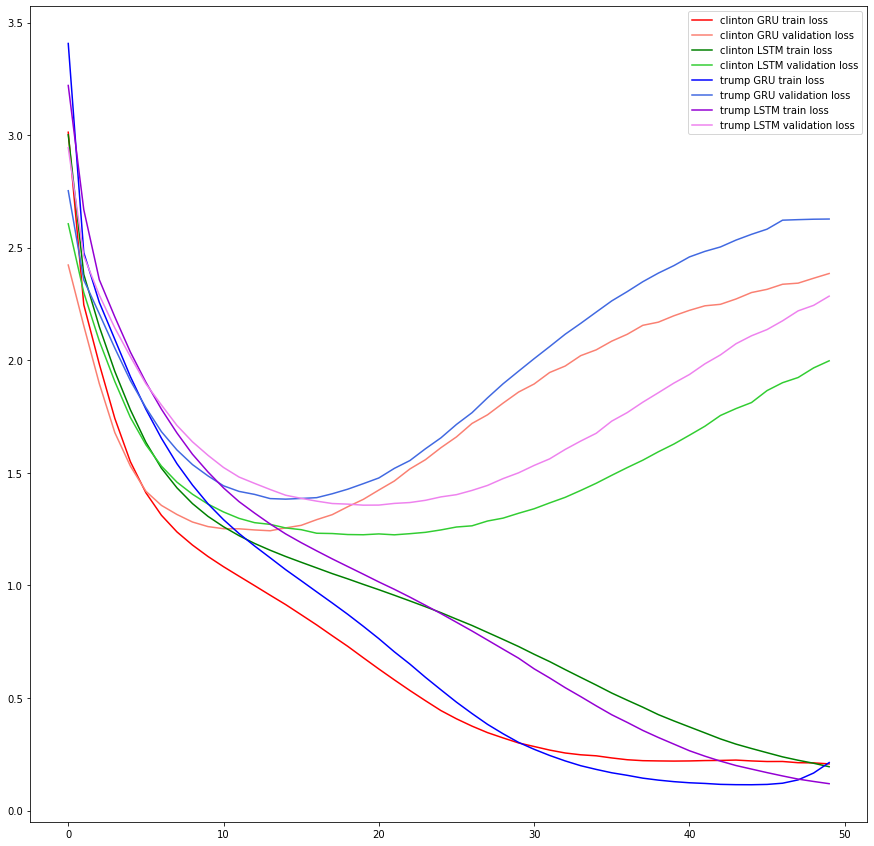

In [37]:
from matplotlib import pyplot as plt
clinton_GRU_loss = clinton_GRU_history.history['loss']
clinton_GRU_val_loss = clinton_GRU_history.history['val_loss']
clinton_LSTM_loss = clinton_LSTM_history.history['loss']
clinton_LSTM_val_loss = clinton_LSTM_history.history['val_loss']

trump_GRU_loss = trump_GRU_history.history['loss']
trump_GRU_val_loss = trump_GRU_history.history['val_loss']
trump_LSTM_loss = trump_LSTM_history.history['loss']
trump_LSTM_val_loss = trump_LSTM_history.history['val_loss']

plt.figure(figsize=(15,15))
plt.plot(range(epochs), clinton_GRU_loss, label='clinton GRU train loss', color='red')
plt.plot(range(epochs), clinton_GRU_val_loss, label='clinton GRU validation loss', color='salmon')
plt.plot(range(epochs), clinton_LSTM_loss, label='clinton LSTM train loss', color='green')
plt.plot(range(epochs), clinton_LSTM_val_loss, label='clinton LSTM validation loss', color='limegreen')

plt.plot(range(epochs), trump_GRU_loss, label='trump GRU train loss', color='blue')
plt.plot(range(epochs), trump_GRU_val_loss, label='trump GRU validation loss', color='royalblue')
plt.plot(range(epochs), trump_LSTM_loss, label='trump LSTM train loss', color='darkviolet')
plt.plot(range(epochs), trump_LSTM_val_loss, label='trump LSTM validation loss', color='violet')

plt.legend()
plt.show()



In [38]:
clinton_GRU_best_epoch = np.argmin(clinton_GRU_val_loss)+1
clinton_LSTM_best_epoch = np.argmin(clinton_LSTM_val_loss)+1

trump_GRU_best_epoch = np.argmin(trump_GRU_val_loss)+1
trump_LSTM_best_epoch = np.argmin(trump_LSTM_val_loss)+1

print(f'Clinton GRU model best epoch: {clinton_GRU_best_epoch}')
print(f'Clinton LSTM model best epoch: {clinton_LSTM_best_epoch}')

print(f'trump GRU model best epoch: {trump_GRU_best_epoch}')
print(f'trump LSTM model best epoch: {trump_LSTM_best_epoch}')

Clinton GRU model best epoch: 14
Clinton LSTM model best epoch: 22
trump GRU model best epoch: 15
trump LSTM model best epoch: 20


In [46]:
clinton_GRU.load_weights('./clinton_GRU_training_checkpoints/ckpt_'+str(clinton_GRU_best_epoch))
clinton_LSTM.load_weights('./clinton_LSTM_training_checkpoints/ckpt_'+str(clinton_LSTM_best_epoch))

trump_GRU.load_weights('./trump_GRU_training_checkpoints/ckpt_'+str(trump_GRU_best_epoch))
trump_LSTM.load_weights('./trump_LSTM_training_checkpoints/ckpt_'+str(trump_LSTM_best_epoch))

In [55]:
clinton_GRU.load_weights('./clinton_GRU_training_checkpoints/ckpt_'+str(epochs))
clinton_LSTM.load_weights('./clinton_LSTM_training_checkpoints/ckpt_'+str(epochs))

trump_GRU.load_weights('./trump_GRU_training_checkpoints/ckpt_'+str(epochs))
trump_LSTM.load_weights('./trump_LSTM_training_checkpoints/ckpt_'+str(epochs))

In [56]:
start = time.time()
states = None
next_char = tf.constant([' '])

generated_text = clinton_GRU.generate_text(200, next_char)
end = time.time()
print(generated_text, '\n\n'+'_'*80)
print('\nRun time:', end-start)

 new Government also, as my own land, eshate in the last two fellow Americans all across America. Thank you. Government workers, coming harder than ever befin to stab pepurity to all of our efforts to  

________________________________________________________________________________

Run time: 5.727677583694458


In [57]:
start = time.time()
states = None
next_char = tf.constant([' '])

generated_text = clinton_LSTM.generate_text(200, next_char)
end = time.time()
print(generated_text, '\n\n'+'_'*80)
print('\nRun time:', end-start)

 strong stand to seize this place, and the world's still frending. They forge our economic programs were protected, the world cleans. Let me say gear for both parties in every year. Most of the minimum 

________________________________________________________________________________

Run time: 6.5325236320495605


In [58]:
start = time.time()
states = None
next_char = tf.constant([' '])

generated_text = trump_GRU.generate_text(200, next_char)
end = time.time()
print(generated_text, '\n\n'+'_'*80)
print('\nRun time:', end-start)

 lowest level in 18 years. Walls work 100 percent. They're doing it down, ke there. In 2id, we got a loughter a year. It having to holone especially those who use new domas system. Otam. They won't be  

________________________________________________________________________________

Run time: 6.836702823638916


In [59]:
start = time.time()
states = None
next_char = tf.constant([' '])

generated_text = trump_LSTM.generate_text(200, next_char)
end = time.time()
print(generated_text, '\n\n'+'_'*80)
print('\nRun time:', end-start)

 chosel chaim so meant her in a now mine, in she fail, more if it is to tell you that we are talking about kelp America sure that you want it thousand. My follow inerpired up tratievesthe regulations a 

________________________________________________________________________________

Run time: 7.367285251617432
